In [1]:
from ssd import SSD300

import matplotlib.pyplot as plt

from keras.preprocessing import image
from scipy.misc import imread
from scipy.misc import imresize
import numpy as np
import pickle
from keras.applications.imagenet_utils import preprocess_input
from ssd_utils import BBoxUtility

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

In [3]:
input_shape = (300, 300, 3)
NUM_CLASSES = 21

In [4]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
weight_path = './data/'
model.load_weights(weight_path + 'mawile_ssd_keras_weight2.hdf5', by_name=True)

In [5]:
pkl_path = './data/pickles/'
pkl_file = 'mawile.pkl'
gt = pickle.load(open(pkl_path + pkl_file, 'rb'))
keys = sorted(gt.keys())
val_keys = keys
num_val = len(val_keys)

priors = pickle.load(open(pkl_path + 'prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [6]:
import random
path_prefix = './data/images/'
inputs = []
images = []
predict_num = 5

for i in range(0, predict_num):
    num = random.randint(0, len(val_keys))

    img_path = path_prefix + sorted(val_keys)[num]
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())

inputs = preprocess_input(np.array(inputs))

In [7]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

5/5 [==============================] - 8s 2s/step


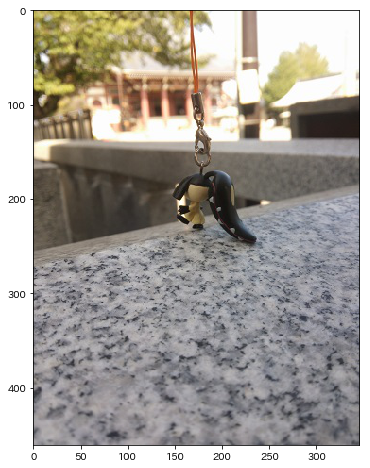

0 5 1 [1.0]


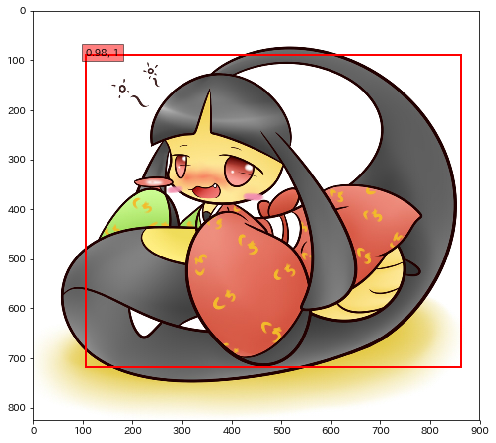

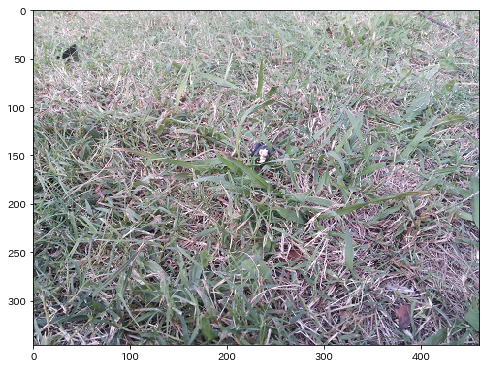

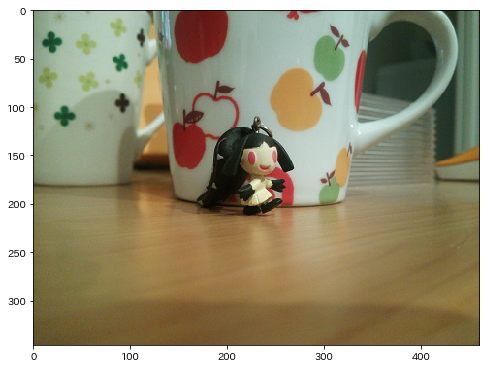

0 5 1 [1.0]


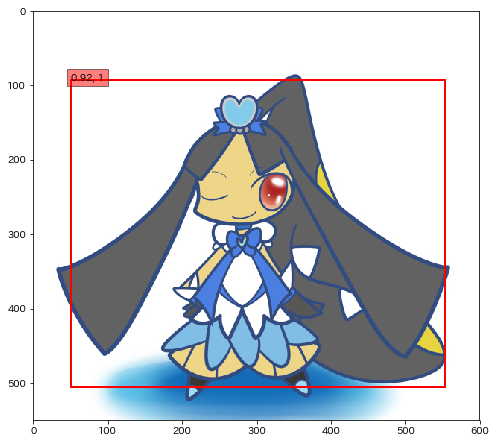

In [8]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        print(i, len(images), label, top_label_indices)
        color = [1.0, 0.0, 0.0, 1.0]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()